In [ ]:
import pandas as pd
!pip install yfinance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import time
from google.colab import files
import yfinance as yf
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import multiprocessing as mp
import datetime as dt
from multiprocessing import Process
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
nlp = pipeline("sentiment-analysis", model = finbert, tokenizer = tokenizer)
sentiment_dict = {'Negative':-1, 'Neutral':0, 'Positive': 1}
ticker_list = ['MSFT','GOOG', 'META','TSLA','AAPL']


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 11.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
# functions to Retrieve financial info and feature engineer
def pull_news(ticker):
    path = '/content/drive/MyDrive/FInal_project_ml/News Data/'+ticker+'_news.csv'
    news_df = pd.read_csv(path)
    news_list = news_df['headline'].to_list()
    print('success1')
    result = nlp(news_list)
    print('success2')
    result = pd.DataFrame(result)
    news_df["sentiment"] = [sentiment_dict[k]for k in result['label']]  
    news_df['date'] = pd.to_datetime(news_df['date'], format = '%m-%d-%y')  
    mean_sentiment = news_df.set_index('date').groupby(pd.Grouper(freq='1D')).mean()
    mean_sentiment.to_csv(ticker+'_sentiment.csv')

def get_financials(ticker, start):
    data = yf.download(str(ticker), start)
    data['ticker'] = ticker
    data = data.rename(columns = {'Adj Close': 'adj_close'})
    data = data.reset_index()
    print('success!')
    return data

def EWMA(data, ndays): 
    EMA = pd.Series(data['close'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                 name = 'EWMA_' + str(ndays)) 
    data = data.join(EMA) 
    return data

def rsi(close, periods = 14):
    
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

def BBANDS(data, window):
    MA = data.close.rolling(window).mean()
    SD = data.close.rolling(window).std()
    data['MiddleBand'] = MA
    data['UpperBand'] = MA + (2 * SD) 
    data['LowerBand'] = MA - (2 * SD)
    return data

def prep_financials(df):
    df = pd.DataFrame(df)
    df.set_index('date')
    df['pct_change'] = (df['close'].shift(-1) - df['close'])/df['close']
    df['10mda'] = df['close'].rolling(10).mean()
    df['20mda'] = df['close'].rolling(20).mean()
    df['50mda'] = df['close'].rolling(50).mean()
    df['100mda'] = df['close'].rolling(100).mean()
    df['target'] = [1 if df['pct_change'].loc[i] >0.015 else 0 for i in df.index]
    df = EWMA(df, 20)
    df = EWMA(df, 50) 
    df = EWMA(df, 100)
    df['rsi'] = rsi(df['close'])
    df = BBANDS(df, 20)
    df.fillna(df['close'], inplace=True)
    df.drop(['pct_change'], axis=1, inplace=True)
    df.reset_index()
    return df

In [ ]:
import datetime as dt
if __name__ == "__main__":
    ticker_list = ['MSFT','GOOG', 'META','TSLA','AAPL']
    processes = []
    proc = Process(target=pull_news)
    processes.append(proc)
    proc.start()

    for tick in ticker_list:
        proc = Process(target =pull_news, args=(tick,))
        processes.append(proc)
        proc.start()
    
    for proc in processes:
        proc.join()


Process Process-1:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
TypeError: pull_news() missing 1 required positional argument: 'ticker'
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


success1success1

success1
success1
success1
success2
success2
success2
success2
success2


In [ ]:
def count_news(ticker):
    headline_nums = []
    path = '/content/drive/MyDrive/FInal_project_ml/News Data/'+ticker+'_news.csv'
    news_df = pd.read_csv(path) 
    news_df['date'] = pd.to_datetime(news_df['date'], format = '%m-%d-%y') 
    num_df = news_df.set_index('date').groupby(pd.Grouper(freq='1D')).count()
    return num_df

In [ ]:
#Complete financial info retrieval
finance_dfs = []
for tick in ticker_list:
    data = get_financials(tick, dt.date(2018,1, 1))
    finance_dfs.append(data)

#read to csv
full_finance = pd.concat(finance_dfs).rename(columns = {'Date':'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'})
full_finance.to_csv('finance.csv', index = False)


[*********************100%***********************]  1 of 1 completed
success!
[*********************100%***********************]  1 of 1 completed
success!
[*********************100%***********************]  1 of 1 completed
success!
[*********************100%***********************]  1 of 1 completed
success!
[*********************100%***********************]  1 of 1 completed
success!


# Single Company implementation

## EDA, Data Cleaning and Model Building
All data collection and initial prep is completed at this point.

In [ ]:
sentiment_dfs = []
for i in ticker_list:
  data = pd.read_csv('/content/drive/MyDrive/FInal_project_ml/Sentiment data/'+i+'_sentiment.csv')
  counts = count_news(i).reset_index()
  print(counts.info())
  data['date'] = pd.to_datetime(data['date'])
  dataframe = pd.merge(data, counts, how = 'inner')
  sentiment_dfs.append(dataframe)
print(sentiment_dfs[1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1856 entries, 0 to 1855
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1856 non-null   datetime64[ns]
 1   headline  1856 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 29.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1856 entries, 0 to 1855
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1856 non-null   datetime64[ns]
 1   headline  1856 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 29.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1857 entries, 0 to 1856
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1857 non-null   datetime64[ns]
 1   headline  1857 non-null   int64         
dtyp

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1856 entries, 0 to 1855
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1856 non-null   datetime64[ns]
 1   sentiment  1410 non-null   float64       
 2   headline   1856 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 58.0 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       1295 non-null   int64         
 1   date        1295 non-null   datetime64[ns]
 2   open        1295 non-null   float64       
 3   high        1295 non-null   float64       
 4   low         1295 non-null   float64       
 5   close       1295 non-null   float64       
 6   adj_close   1295 non-null   float64       
 7   volume      1295 non-null   int64       

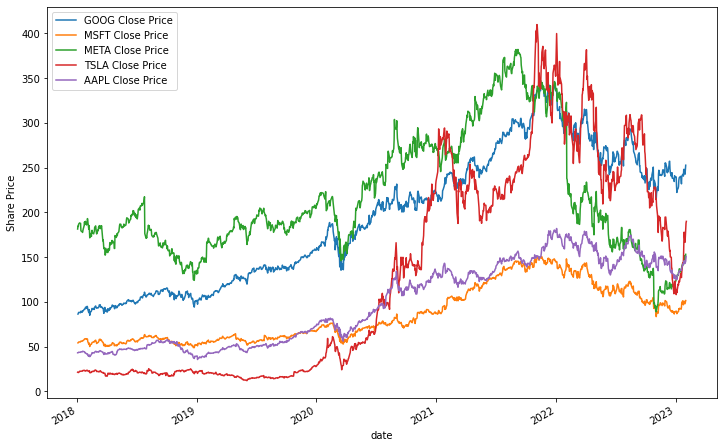

In [ ]:
financials = pd.read_csv('/content/drive/MyDrive/FInal_project_ml/Financial data/finance.csv')
#function to separate dataframe by company
def separate_companies(ticker, df):
    dataframe = df[df['ticker']==ticker]
    return dataframe

#separate dataframes for each company and add new features
df_list = []
for tick in ticker_list:
    data = separate_companies(tick, financials)
    data = prep_financials(data).reset_index()
    data['date'] = pd.to_datetime(data['date'])
    df_list.append(data)

print(sentiment_dfs[1].info())
print(df_list[1].info())
#create final dataframe with sentiment included
goog = pd.merge(df_list[1], sentiment_dfs[1], how = 'inner').set_index('date')
msft = pd.merge(df_list[0], sentiment_dfs[0], how = 'inner').set_index('date')
meta = pd.merge(df_list[2], sentiment_dfs[2], how = 'inner').set_index('date')
tesla = pd.merge(df_list[3], sentiment_dfs[3], how = 'inner').set_index('date')
apple = pd.merge(df_list[4], sentiment_dfs[4], how = 'inner').set_index('date')
print(goog[1:20])
frames = [goog, msft, meta, tesla, apple]
ticker_list = ['GOOG', 'MSFT','META','TSLA','AAPL']
plt.figure(figsize = (12, 8))
for i, frame in enumerate(frames):
  frame['close'].plot(label = ticker_list[i]+' Close Price')
plt.ylabel('Share Price')
plt.legend()
plt.show()

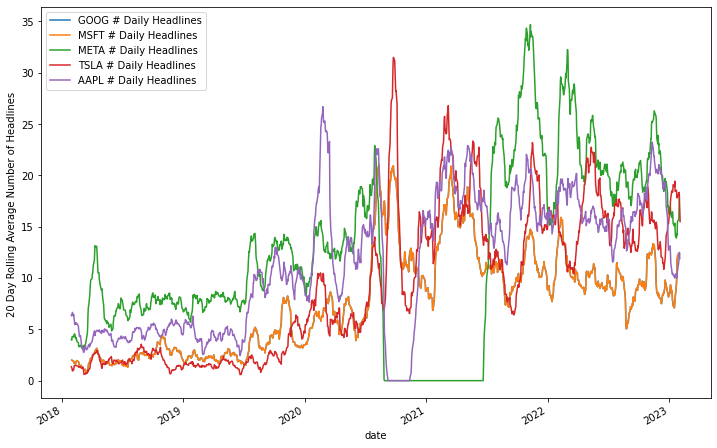

In [ ]:
#EDA and summary stats for compiled datasets
rollings = []
for i, frame in enumerate(frames):
  frame['average headlines'] = frame['headline'].rolling(20).mean()
  rollings.append(frame)
plt.figure(figsize = (12, 8))
for i, frame in enumerate(rollings):
  frame['average headlines'].plot(label = ticker_list[i]+' # Daily Headlines')
plt.legend()
plt.ylabel('20 Day Rolling Average Number of Headlines ')
plt.show()


In [ ]:
#Format data to be passed into LSTM network
print(meta.loc['01-07-2020':'01-07-2021'])

            index        open        high         low       close   adj_close  \
date                                                                            
2020-01-07   3096  212.820007  214.580002  211.750000  213.059998  213.059998   
2020-01-08   3097  213.000000  216.240005  212.610001  215.220001  215.220001   
2020-01-09   3098  217.539993  218.380005  216.279999  218.300003  218.300003   
2020-01-10   3099  219.199997  219.880005  217.419998  218.059998  218.059998   
2020-01-13   3100  219.600006  221.970001  219.210007  221.910004  221.910004   
...           ...         ...         ...         ...         ...         ...   
2020-12-31   3345  272.000000  277.089996  269.809998  273.160004  273.160004   
2021-01-04   3346  274.779999  275.000000  265.200012  268.940002  268.940002   
2021-01-05   3347  268.290009  272.399994  268.209991  270.970001  270.970001   
2021-01-06   3348  262.000000  267.750000  260.010010  263.309998  263.309998   
2021-01-07   3349  265.89999

In [ ]:
#LSTM Framework
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
!pip install keras_tuner
import keras_tuner
LR = 0.05
def build_model(hp):
  model = Sequential()
  hidden = hp.Choice('n_hidden', [0,1,2,3,4])
  model.add(LSTM(units = hp.Int('neurons_visible', min_value = X_train.shape[2], max_value = 100, step = 20),
                activation = hp.Choice('activate1', ['tanh', 'sigmoid', 'relu']),
                input_shape = (X_train.shape[1], X_train.shape[2]),
                return_sequences = True if hidden >0 else False))
  #Configure hidden layers based on random search determined hidden layer number
  if hidden > 0:
    for num in range(hidden):
      model.add(Dropout(hp.Float('dropout' +str(num+1), min_value = 0.05, max_value = 0.95, step = 0.1)))
      model.add(LSTM(units = hp.Int('neurons_hidden'+str(num+1), min_value = 8, max_value = 50, step = 10),
                     activation = 'relu', return_sequence = True if num != hidden else False))
      
  model.add(Dropout(hp.Float('dropout_visible', min_value = 0.05, max_value = 0.95, step = 0.1)))
  model.add(Dense(units = 1, activation = 'sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = LR), metrics = [Precision, 'accuracy'])
  
  return model

LR_decay = ReduceLROnPlateau('loss', patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
Early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
tune = keras_tuner.RandomSearch(build_model, objective = 'val_loss', max_trials = 50, seed = 1)

tune.search(X_train, Y_train, epochs = 200, batch_size = 24, validation_split = 0.2, callbacks = [LR_decay, Early_stop])

LSTM_model = tune.get_best_models()[0]
LSTM_model.save('/content/drive/MyDrive/FInal_project_ml/models/LSTM_model.h5')

# Prophet Model Part


For this section is how we gonna fit the prophet model by using miscosoft company stock price data. The best hyperparameter we get by using the cross-validation

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid

In [ ]:
# Uploaded stock price csv
from google.colab import files
uploaded = files.upload()

Saving finance.csv to finance.csv


In [ ]:
finance_data = pd.read_csv("finance.csv")
MSFT_Data = finance_data[finance_data['ticker']=='MSFT']
# This function is used to get the train data and test data
def data_preparation(df):
  data=df[["date","adj_close"]]
  data = data.rename(columns = {'date':'ds', 'adj_close':'y'})
  return data

In [ ]:
# Define parameter grid to search over
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
}

# Initialize minimum error and best parameters
min_error = float('inf')
best_params = {}

# Loop through all parameter combinations
for params in ParameterGrid(param_grid):
    print('Testing parameters:', params)

    # Initialize Prophet model with specified hyperparameters
    model = Prophet(**params)
    model.fit(data_preparation(MSFT_Data))

    # Perform time series cross-validation
    df_cv = cross_validation(model=model, initial='1000 days', horizon='10 days', period='10 days')

    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv)

    # Calculate mean cross-validation error
    mean_cv_error = df_metrics['mse'].mean()

    # Update minimum error and best parameters if new minimum is found
    if mean_cv_error < min_error:
        min_error = mean_cv_error
        best_params = params

# Print best hyperparameters and corresponding error
print('Best parameters:', best_params)
print('Minimum cross-validation error:', min_error)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/y2nm6vj3.json


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/a25wq4jr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28660', 'data', 'file=/tmp/tmp2t_fu8bu/y2nm6vj3.json', 'init=/tmp/tmp2t_fu8bu/a25wq4jr.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modely97nm1h0/prophet_model-20230228153211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:32:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:32:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/_nuuuhhr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/iefxtkw2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1053', 'data', 'file=/tmp/tmp2t_fu8bu/_nuuuhhr.json', 'init=/tmp/tmp2t_fu8bu/iefxtkw2.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modelo8mlx8_e/prophet_model-20230228153212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:32:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:32:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/hlnggcz1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/r_5xax3w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


15:32:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/237ny3tc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/43326mcr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22917', 'data', 'file=/tmp/tmp2t_fu8bu/237ny3tc.json', 'init=/tmp/tmp2t_fu8bu/43326mcr.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modell641nkeg/prophet_model-20230228153259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:32:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:32:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/wesgva4d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/18odxiyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/rjscpn3a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47993', 'data', 'file=/tmp/tmp2t_fu8bu/fcu4ynhm.json', 'init=/tmp/tmp2t_fu8bu/rjscpn3a.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modela_egxvf7/prophet_model-20230228153338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:33:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:33:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/wqco8p9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/ke5rw5rs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38920', 'data', 'file=/tmp/tmp2t_fu8bu/wqco8p9z.json', 'init=/tmp/tmp2t_fu8bu/ke5rw5rs.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modeluz2_7l4i/prophet_model-20230228153339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:33:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:33:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/lzdyw9x3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/r9n72mlx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/f7zjfqbs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92594', 'data', 'file=/tmp/tmp2t_fu8bu/5j8c9ig3.json', 'init=/tmp/tmp2t_fu8bu/f7zjfqbs.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modelm8dy7_4y/prophet_model-20230228153422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:34:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:34:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/xdq37e04.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/xumew4yw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27541', 'data', 'file=/tmp/tmp2t_fu8bu/xdq37e04.json', 'init=/tmp/tmp2t_fu8bu/xumew4yw.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modelptle267q/prophet_model-20230228153423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:34:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:34:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/dl_toyng.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/ylobdj63.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


15:35:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/ry675kea.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/98l38u3n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22034', 'data', 'file=/tmp/tmp2t_fu8bu/ry675kea.json', 'init=/tmp/tmp2t_fu8bu/98l38u3n.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modelnhthe2kg/prophet_model-20230228153506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:35:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:35:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/wjzmk_e6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/ekbivjwe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/ob20bxq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95634', 'data', 'file=/tmp/tmp2t_fu8bu/aeq37lln.json', 'init=/tmp/tmp2t_fu8bu/ob20bxq9.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modelbkahzl2v/prophet_model-20230228153549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:35:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:35:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/8uy4e_sv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/lp3om4ga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6842', 'data', 'file=/tmp/tmp2t_fu8bu/8uy4e_sv.json', 'init=/tmp/tmp2t_fu8bu/lp3om4ga.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modelkje0s3vt/prophet_model-20230228153550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:35:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:35:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/or_79cgx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/xgzpe5sh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


15:36:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/75ej7ga1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/2wmasmul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17159', 'data', 'file=/tmp/tmp2t_fu8bu/75ej7ga1.json', 'init=/tmp/tmp2t_fu8bu/2wmasmul.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_model_mpjwb19/prophet_model-20230228153647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:36:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:36:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/w7x9xvo1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/ulxf4wiz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


15:38:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/1wkd9ubd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/y6a5rm5l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24826', 'data', 'file=/tmp/tmp2t_fu8bu/1wkd9ubd.json', 'init=/tmp/tmp2t_fu8bu/y6a5rm5l.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_model1_3idg97/prophet_model-20230228153819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:38:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:38:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/abil0y6i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/bl8_gy41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/mgr29z1y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49060', 'data', 'file=/tmp/tmp2t_fu8bu/jq604jg0.json', 'init=/tmp/tmp2t_fu8bu/mgr29z1y.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modelma41mapr/prophet_model-20230228153950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/0bw400ap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/2dlnswa3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29458', 'data', 'file=/tmp/tmp2t_fu8bu/0bw400ap.json', 'init=/tmp/tmp2t_fu8bu/2dlnswa3.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modelf5dcmpb1/prophet_model-20230228153952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/h_pohogq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/ar1ic6yn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


15:41:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/qpq2huq4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/pyfkrdeu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28750', 'data', 'file=/tmp/tmp2t_fu8bu/qpq2huq4.json', 'init=/tmp/tmp2t_fu8bu/pyfkrdeu.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_model95be4744/prophet_model-20230228154125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/nfpupv5h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/p4vkbg15.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


15:42:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/ydw6zatg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/l2rv_1go.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54569', 'data', 'file=/tmp/tmp2t_fu8bu/ydw6zatg.json', 'init=/tmp/tmp2t_fu8bu/l2rv_1go.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modelcmefze7s/prophet_model-20230228154259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:43:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/2d2oin75.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/bd2n0b3v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


15:44:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/r_dl_ivx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/uj13g5zd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22868', 'data', 'file=/tmp/tmp2t_fu8bu/r_dl_ivx.json', 'init=/tmp/tmp2t_fu8bu/uj13g5zd.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modelovb6t8tg/prophet_model-20230228154444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:44:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:44:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/pnlnl0ex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/000nv_wv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/oq9eltfp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9478', 'data', 'file=/tmp/tmp2t_fu8bu/qz_kj7c8.json', 'init=/tmp/tmp2t_fu8bu/oq9eltfp.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_model2v9hcnxb/prophet_model-20230228154733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:47:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:47:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/5w0dgq1d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/t1288ef0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24021', 'data', 'file=/tmp/tmp2t_fu8bu/5w0dgq1d.json', 'init=/tmp/tmp2t_fu8bu/t1288ef0.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modelkik0u17l/prophet_model-20230228154736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:47:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:47:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/_27pl_8f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/vv2bvva5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


15:49:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/saovbdhm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/9c7qn7bz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61334', 'data', 'file=/tmp/tmp2t_fu8bu/saovbdhm.json', 'init=/tmp/tmp2t_fu8bu/9c7qn7bz.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modelyi16cl5w/prophet_model-20230228154943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:49:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:49:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/pgm6v0_o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/y823m34_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


15:51:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/4aj7k8rg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/kik0bpqs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76932', 'data', 'file=/tmp/tmp2t_fu8bu/4aj7k8rg.json', 'init=/tmp/tmp2t_fu8bu/kik0bpqs.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modeloeh3hrab/prophet_model-20230228155142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:51:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:51:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/4x0x4yj5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/asbc_fm4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


15:53:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/yo1e36l4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/rsguyk4m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99038', 'data', 'file=/tmp/tmp2t_fu8bu/yo1e36l4.json', 'init=/tmp/tmp2t_fu8bu/rsguyk4m.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modelkd8vsdc_/prophet_model-20230228155341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:53:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:53:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/sfveay60.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/_dfk5h9e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


15:55:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/dpsu8zco.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/krbtmzxw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22206', 'data', 'file=/tmp/tmp2t_fu8bu/dpsu8zco.json', 'init=/tmp/tmp2t_fu8bu/krbtmzxw.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modeluej3q9lt/prophet_model-20230228155541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/a9llzkam.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/dgrhy0ie.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/ey94lfa3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58247', 'data', 'file=/tmp/tmp2t_fu8bu/ynpx_21o.json', 'init=/tmp/tmp2t_fu8bu/ey94lfa3.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_modeluol0vyur/prophet_model-20230228155741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-10-06 00:00:00 and 2023-02-13 00:00:00


  0%|          | 0/87 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/vuf_pe7w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/c318aw_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80419', 'data', 'file=/tmp/tmp2t_fu8bu/vuf_pe7w.json', 'init=/tmp/tmp2t_fu8bu/c318aw_4.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_model_2ueeqd2/prophet_model-20230228155744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/x6ep03jl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/tifcr55f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Best parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Minimum cross-validation error: 151.37441962610882


In [ ]:
# We use the best parameter to fit the model
final_model = Prophet(**best_params)
final_model.fit(data_preparation(MSFT_Data))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/852htkl1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2t_fu8bu/pk4_3lb_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6718', 'data', 'file=/tmp/tmp2t_fu8bu/852htkl1.json', 'init=/tmp/tmp2t_fu8bu/pk4_3lb_.json', 'output', 'file=/tmp/tmp2t_fu8bu/prophet_model4ndiwz03/prophet_model-20230228160551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:05:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:05:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds        yhat  yhat_lower  yhat_upper
0    2018-01-02   82.617751   74.263368   90.727010
1    2018-01-03   82.717682   74.082083   90.899851
2    2018-01-04   82.547800   75.048056   90.832293
3    2018-01-05   82.451125   74.945562   90.991374
4    2018-01-08   81.915603   73.866294   90.260207
...         ...         ...         ...         ...
1390 2023-05-30  221.585676  190.484983  254.309147
1391 2023-05-31  221.884841  189.934891  255.559992
1392 2023-06-01  221.475005  187.849700  253.929695
1393 2023-06-02  221.281150  188.111709  256.022226
1394 2023-06-03  220.533550  186.136428  255.634967

[1395 rows x 4 columns]


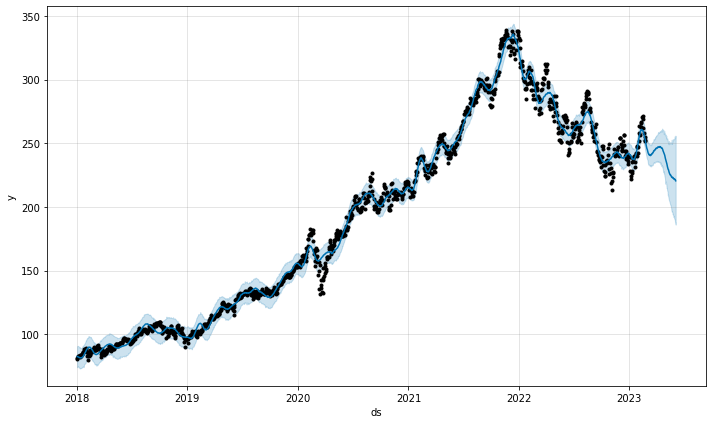

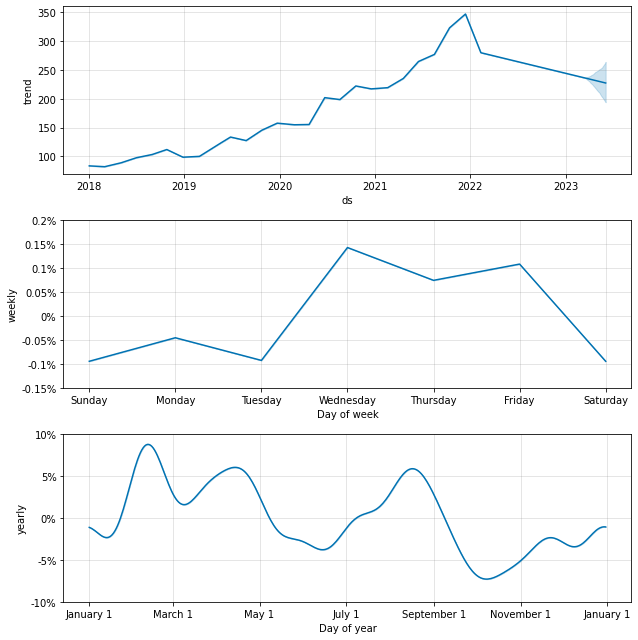

In [ ]:
future = final_model.make_future_dataframe(periods=100)
validation_predict = final_model.predict(future)
print(validation_predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
fig = final_model.plot(validation_predict)
fig1 = final_model.plot_components(validation_predict)